## Sequential feature selection algorithms
## SBS

In [1]:
import numpy as np
import pandas as pd

#df_wine = pd.read_csv('wine.data', header=None)
df_wine = pd.read_csv('https://archive.ics.uci.edu/'
                    'ml/machine-learning-databases/wine/wine.data',
                      header=None)
 
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

print('Class labels', np.unique(df_wine['Class label']))
df_wine.head()

Class labels [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [2]:
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.3, 
                     random_state=0, 
                     stratify=y)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(124, 13) (54, 13)
(124,) (54,)


In [3]:
from sklearn.preprocessing import StandardScaler
# mean-->0 / std-->1

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)


## SBS

In [5]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


class SBS():                                                              #模型建構方法
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
        
    
    def fit(self, X, y):                                                  # 投入資料並計算
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)
        dim = X_train.shape[1]                                             # 記錄特徵數
        self.indices_ = tuple(range(dim))                                  # ()-->特徵index(原始：0,1,2,3...12)
        
        # 記錄每次的特徵index組合
        self.subsets_ = [self.indices_]                             
        
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


class SBS():                                                              #模型建構方法
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
        
    
    def fit(self, X, y):                                                  # 投入資料並計算
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)
        dim = X_train.shape[1]                                             # 記錄特徵數
        self.indices_ = tuple(range(dim))                                  # ()-->特徵index(原始：0,1,2,3...12)
        self.subsets_ = [self.indices_]                                    #二維  # 記錄每次的特徵index組合
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)            # 呼叫_calc_score(),針對特徵index進行評分
        self.scores_ = [score]                                             # 記錄每次評分結果

        while dim > self.k_features:
            scores = []#記錄評分
            subsets = []#記錄特徵組合
            
            # 求階乘(原始：13取12)
            for p in combinations(self.indices_, r=dim - 1):
                #呼叫_calc_score(),針對特徵index進行評分
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                
                #將評分結果加到scores
                scores.append(score)
                
                #記錄特徵組合
                subsets.append(p)

            #計算最佳組合(評分分數最高者的index)
            best = np.argmax(scores)
            
            #以評分最高的index反推是哪一組特徵組合
            self.indices_ = subsets[best]
            
            #記錄到 indices_
            self.subsets_.append(self.indices_)
            
            dim -= 1
            
            # 將評分結果加到 scores_
            self.scores_.append(scores[best])
            
        self.k_score_ = self.scores_[-1]

        return self

    #返回指定的特徵資料
    def transform(self, X):
        return X[:, self.indices_]
    
    #評分
    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score #二維
        
        #呼叫_calc_score(),針對特徵index進行評分
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        
        # 記錄每次評分結果
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []#記錄評分
            subsets = []#記錄特徵組合
            
            # 求階乘(原始：13取12)
            for p in combinations(self.indices_, r=dim - 1):
                #呼叫_calc_score(),針對特徵index進行評分
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                
                #將評分結果加到scores
                scores.append(score)
                
                #記錄特徵組合
                subsets.append(p)

            #計算最佳組合(評分分數最高者的index)
            best = np.argmax(scores)
            
            #以評分最高的index反推是哪一組特徵組合
            self.indices_ = subsets[best]
            
            #記錄到 indices_
            self.subsets_.append(self.indices_)
            
            dim -= 1
            
            # 將評分結果加到 scores_
            self.scores_.append(scores[best])
            
        self.k_score_ = self.scores_[-1]

        return self

    #返回指定的特徵資料
    def transform(self, X):
        return X[:, self.indices_]
    
    #評分
    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

d:\anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
d:\anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avo

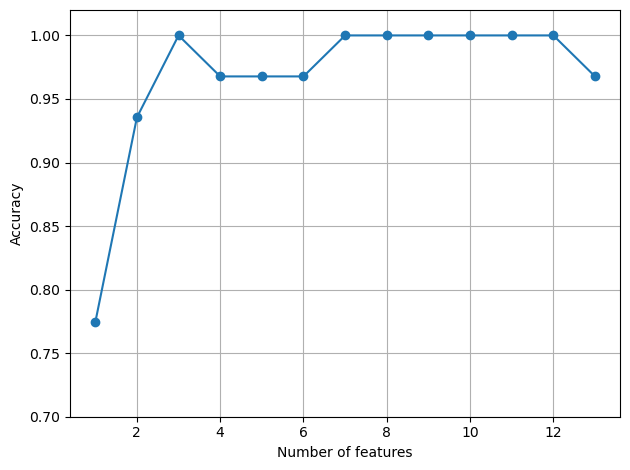

In [8]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

# selecting features
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

# 將存在 subsets_ 的各組特徵index 統計其數量
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('images/04_08.png', dpi=300)
plt.show()

In [7]:
k3 = list(sbs.subsets_[10])
print(k3)
print(df_wine.columns[1:][k3])

[0, 1, 11]
Index(['Alcohol', 'Malic acid', 'OD280/OD315 of diluted wines'], dtype='object')


## 直接使用knn模型，計算 13 特徵數的結果

In [ ]:
# 直接使用knn模型，計算 13 特徵數的結果
knn.fit(X_train_std, y_train)
print('Training accuracy:', knn.score(X_train_std, y_train))
print('Test accuracy:', knn.score(X_test_std, y_test))

Training accuracy: 0.967741935483871
Test accuracy: 0.9629629629629629


In [ ]:
knn.fit(X_train_std[:, k3], y_train)
print('Training accuracy:', knn.score(X_train_std[:, k3], y_train))
print('Test accuracy:', knn.score(X_test_std[:, k3], y_test))

Training accuracy: 0.9516129032258065
Test accuracy: 0.9259259259259259


# Assessing feature importance with Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = df_wine.columns[1:]

forest = RandomForestClassifier(n_estimators=500,
                                random_state=1)

forest.fit(X_train, y_train)
#分析特徵的重要性(值大重要性高)
importances = forest.feature_importances_
print(importances)

[0.11852942 0.02564836 0.01327854 0.02236594 0.03135708 0.05087243
 0.17475098 0.01335393 0.02556988 0.1439199  0.058739   0.13616194
 0.1854526 ]


 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529
 6) Hue                            0.058739
 7) Total phenols                  0.050872
 8) Magnesium                      0.031357
 9) Malic acid                     0.025648
10) Proanthocyanins                0.025570
11) Alcalinity of ash              0.022366
12) Nonflavanoid phenols           0.013354
13) Ash                            0.013279


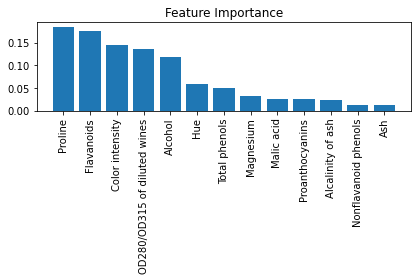

In [ ]:
indices = np.argsort(importances)[::-1]# 依重要性大到小排序，取得index

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
#plt.savefig('images/04_09.png', dpi=300)
plt.show()

In [ ]:
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(forest, threshold=0.1, prefit=True)
X_selected = sfm.transform(X_train)
print('Number of features that meet this threshold criterion:', 
      X_selected.shape[1])

Number of features that meet this threshold criterion: 5


Now, let's print the 3 features that met the threshold criterion for feature selection that we set earlier (note that this code snippet does not appear in the actual book but was added to this notebook later for illustrative purposes):

In [ ]:
for f in range(X_selected.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529
